In [7]:
import math
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.dates as mdates
import pandas as pd
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt

import sklearn.metrics as sm

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import datetime as dt
from scipy import stats
from sklearn.model_selection import LearningCurveDisplay

raw_df = pd.read_csv('google-stock-dataset-Daily.csv')
raw_df = raw_df.drop(['Unnamed: 0', 'Adj Close'], axis=1)
raw_df.set_index("Date", inplace=True)
raw_df

,Price,High,Low,Close,Volume
Date,,,,,
2013-04-15,19.67,19.94,19.44,19.57,98025876
2013-04-16,19.68,19.92,19.62,19.85,69610320
2013-04-17,19.69,19.79,19.47,19.58,81398520
2013-04-18,19.65,19.66,19.05,19.17,132767100
2013-04-19,19.25,20.11,19.18,20.02,231895872
...,...,...,...,...,...
2023-03-27,104.62,104.76,101.93,102.46,31120900
2023-03-28,102.44,102.45,99.74,101.03,32057900
2023-03-29,102.28,102.49,100.65,101.39,28779600


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 [Text(-500.0, 0, '2021-04-08'),
  Text(0.0, 0, '2013-04-15'),
  Text(500.0, 0, '2015-04-09'),
  Text(1000.0, 0, '2017-04-03'),
  Text(1500.0, 0, '2019-03-29'),
  Text(2000.0, 0, '2021-03-24'),
  Text(2500.0, 0, '2023-03-20'),
  Text(3000.0, 0, '')])

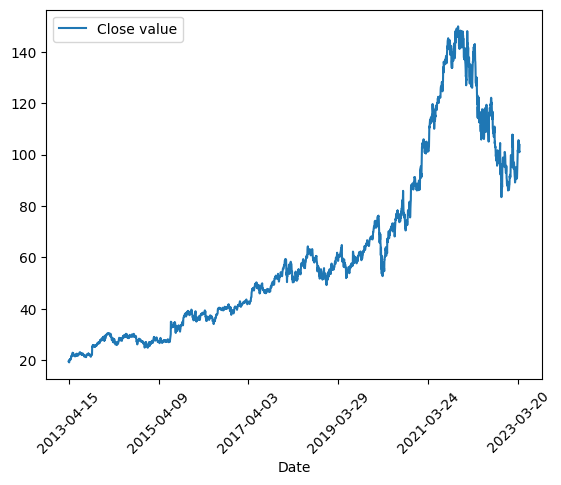

In [8]:
raw_df.plot(y='Close')
plt.legend(['Close value'])
plt.xticks(rotation=45)

In [9]:

def is_stationary(df):
    result = adfuller(df)
    test_statistic = result[0]
    p_value = result[1]
    ciritcal_values = result[4]
    
    for key, value in result[4].items():
        if test_statistic > value:
            return False
    return True


def convert_to_stationary(df):
    df_diff = df.diff().dropna()
    return df_diff


def revert_to_non_stationary(init, stat_df):
    df_rev_diff = np.r_[init, stat_df].cumsum()
   
    return df_rev_diff

stat_df = pd.DataFrame()
for col in list(raw_df):
    if not is_stationary(raw_df[col]):
        stat_df[col] = convert_to_stationary(raw_df[col])
        continue
    stat_df[col] = raw_df[col]
for col in list(stat_df):
    print('Is stationary:', is_stationary(stat_df[col]))

Is stationary: True
Is stationary: True
Is stationary: True
Is stationary: True
Is stationary: True


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

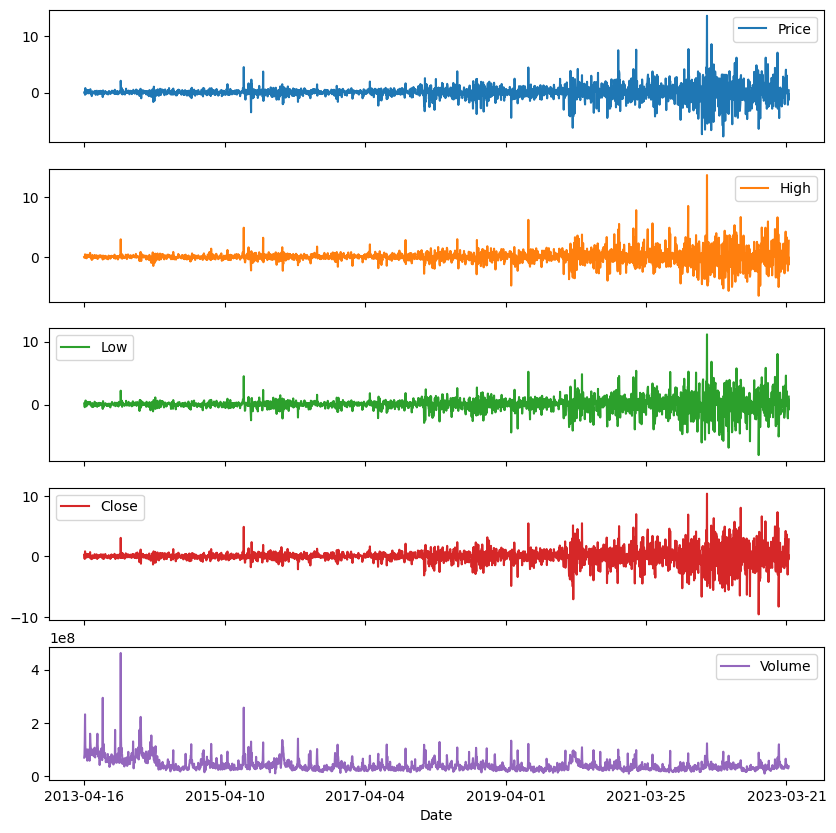

In [10]:
stat_df.plot(subplots=True, figsize=(10, 10))


In [11]:
# x_data, y_data
x_data = stat_df.drop(['Close'],axis=1).values
y_data = stat_df['Close'].values

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0.2, shuffle=False)
y_data

array([ 0.28, -0.27, -0.41, ...,  0.36, -0.5 ,  2.84])

In [27]:
import math
#importing keras modules
from keras.models import Sequential
from keras.layers import Dense, Activation ,Dropout , Flatten , Conv1D ,MaxPooling1D
from keras.layers import LSTM
from keras import losses
from keras import optimizers

def build_model():
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(x_train.shape[1], 1), return_sequences=True))
        model.add(LSTM(32, input_shape=(x_train.shape[1], 1), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
        #model.add(Dropout(d))
        model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
        model.compile(loss='mse',optimizer='adam',metrics=['mae'])
        return model
model = build_model()
#Summary of the Model
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_11 (LSTM)              (None, 32)                20608     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 87713 (342.63 KB)
Trainable params: 87713 (342.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [53]:
from timeit import default_timer as timer
start = timer()
history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=25,
                    validation_split=0.2,
                    verbose=2)
end = timer()
print(end - start)

Epoch 1/25
13/13 - 1s - loss: 0.1153 - val_loss: 0.7701 - 939ms/epoch - 72ms/step
Epoch 2/25
13/13 - 0s - loss: 0.0914 - val_loss: 0.7543 - 90ms/epoch - 7ms/step
Epoch 3/25
13/13 - 0s - loss: 0.0871 - val_loss: 0.7453 - 103ms/epoch - 8ms/step
Epoch 4/25
13/13 - 0s - loss: 0.0861 - val_loss: 0.7386 - 104ms/epoch - 8ms/step
Epoch 5/25
13/13 - 0s - loss: 0.0851 - val_loss: 0.7332 - 103ms/epoch - 8ms/step
Epoch 6/25
13/13 - 0s - loss: 0.0849 - val_loss: 0.7229 - 105ms/epoch - 8ms/step
Epoch 7/25
13/13 - 0s - loss: 0.0844 - val_loss: 0.7226 - 105ms/epoch - 8ms/step
Epoch 8/25
13/13 - 0s - loss: 0.0841 - val_loss: 0.7235 - 105ms/epoch - 8ms/step
Epoch 9/25
13/13 - 0s - loss: 0.0840 - val_loss: 0.7220 - 106ms/epoch - 8ms/step
Epoch 10/25
13/13 - 0s - loss: 0.0838 - val_loss: 0.7189 - 106ms/epoch - 8ms/step
Epoch 11/25
13/13 - 0s - loss: 0.0840 - val_loss: 0.7190 - 105ms/epoch - 8ms/step
Epoch 12/25
13/13 - 0s - loss: 0.0834 - val_loss: 0.7202 - 105ms/epoch - 8ms/step
Epoch 13/25
13/13 - 0s - 

In [54]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

/var/folders/t3/j07lc3w91k7_w481rhm76x2m0000gn/T/ipykernel_4785/1336569470.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
/var/folders/t3/j07lc3w91k7_w481rhm76x2m0000gn/T/ipykernel_4785/1336569470.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation loss')


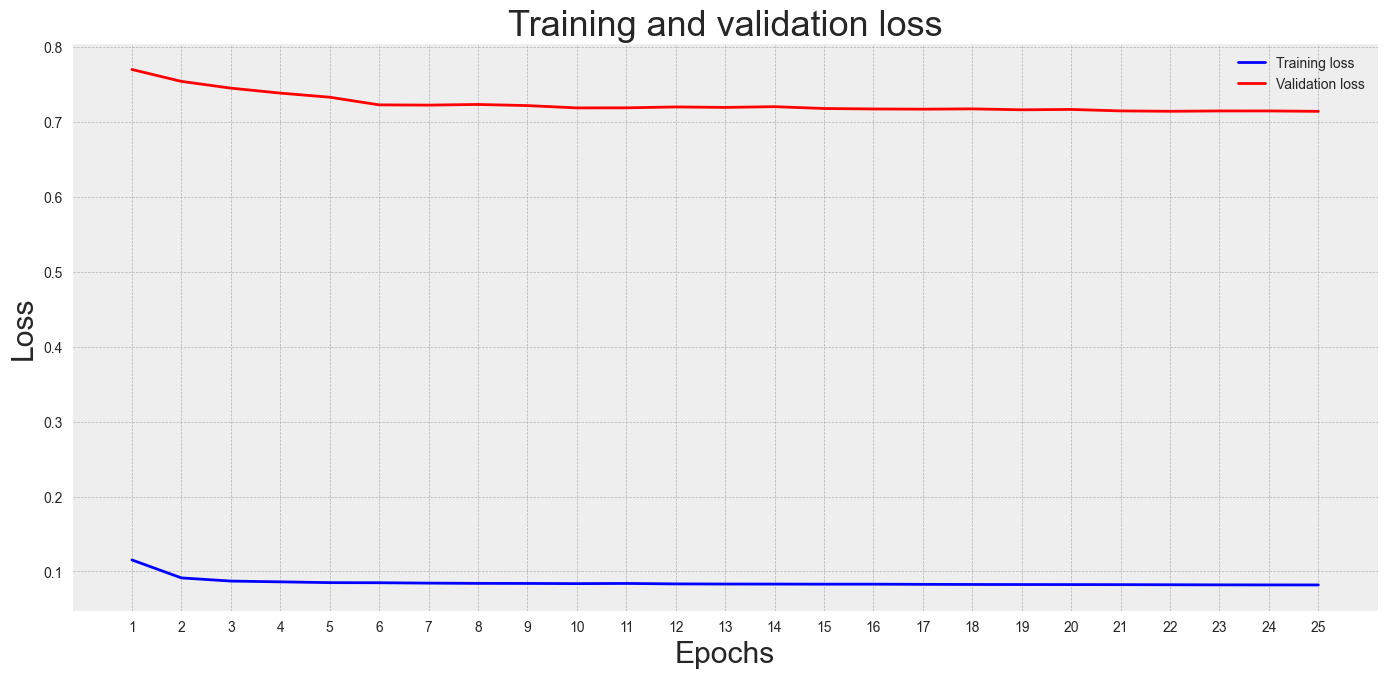

In [55]:

plt.style.use('bmh')

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation loss')
plt.rc('font', size = 18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)

plt.show()

In [56]:
model = keras.Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 4, 100)            40800     
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dense_12 (Dense)            (None, 25)                2525      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123751 (483.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
2007/2007 [==============================] - 3s 1ms/step - loss: 0.4170
Epoch 2/3
2007/2007 [==============================] - 2s 1ms/s

In [57]:
y_predict = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(y_predict - y_test)**2)
rmse


16/16 [==============================] - 0s 2ms/step


0.027734827497506526

In [58]:


x_dates = []
predicted_dates = stat_df.index[x_train.shape[0]:]
restore_point = raw_df['Close'][predicted_dates[0]]
for d in predicted_dates:
    x_dates.append(mdates.date2num(dt.datetime.strptime(d, '%Y-%m-%d')))

/var/folders/t3/j07lc3w91k7_w481rhm76x2m0000gn/T/ipykernel_4785/1164256271.py:22: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.gca().legend('Actual', 'Prediction')


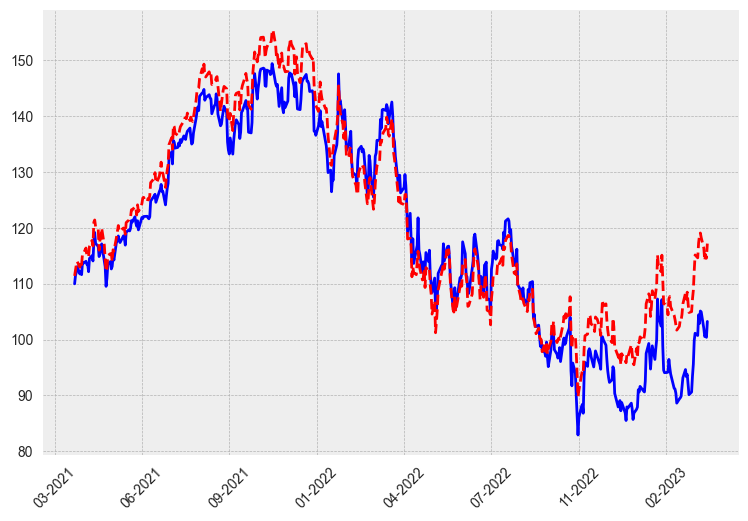

In [59]:


ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=45)

plt.plot(x_dates, revert_to_non_stationary(restore_point, y_test)[1:], color='blue')
plt.plot(x_dates, revert_to_non_stationary(restore_point, y_predict.ravel())[1:], color='red', linestyle='--')
plt.gca().legend('Actual', 'Prediction')
plt.show()


In [60]:
r2_score = sm.r2_score(y_test, y_predict)
print(f"(R^2) score: {round(r2_score, 4)* 100:.2f}%")


(R^2) score: 70.91%
